In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt

In [2]:
dist = torch.distributions.Beta(3, 5)

In [3]:
dist.mean

tensor(0.3750)

In [4]:
from run.run import run
from users.user import User
from assistants.ai_assistant import AiAssistant

In [ ]:
decision_rule_kwargs = dict(
    decision_rule='epsilon_rule',
    decision_rule_parameters=dict(
        epsilon=0.1)
)

run_name = f"{decision_rule_kwargs['decision_rule']}"

trace = run(
    user_model=User,
    user_goal=[0.4, 0.8],
    assistant_model=AiAssistant,
    seed=1,
    user_parameters=(8.0, 0.5),
    inference_learning_rate=1e-6,
    n_step=200,
    **decision_rule_kwargs)

In [ ]:
# Extract data
user_goal = trace["user_goal"]
belief_trace = np.asarray(trace["assistant_belief"])
user_action_trace = np.asarray(trace["user_action"])
assistant_action_trace = np.asarray(trace["assistant_action"]).T
n_epochs = len(user_action_trace)
n_targets = len(user_goal)

In [ ]:
belief_trace.shape

In [ ]:
# Create figure
fig, axes = plt.subplots(
    nrows=n_targets+1, figsize=(15, 8),
    constrained_layout=True)

for target in range(n_targets):
    ax = axes[target]
    
    x = torch.linspace(0., 1., 100)
    
    belief = []
    
    for epoch in range(n_epochs):
        log_c0, log_c1 = belief_trace[epoch, target, :]
        belief_epoch = torch.distributions.Beta(concentration0=np.exp(log_c0), concentration1=np.exp(log_c1)).log_prob(x).exp().numpy()
        belief.append(belief_epoch)
        
    im = ax.imshow(
        np.transpose(belief),
        interpolation="nearest",
        aspect="auto",
        cmap="viridis",
        # vmin=0, vmax=1,
    )

#     epochs = np.arange(n_epochs)

#     a = np.asarray(user_action_trace)
#     idx = a == 0
#     ax.scatter(epochs[idx], assistant_action_trace[idx], c="none", marker='^', edgecolor="C1")
#     idx = a == 1
#     ax.scatter(epochs[idx], assistant_action_trace[idx], c='red', marker='v')

    ax.invert_yaxis()
    ax.yaxis.get_major_locator().set_params(integer=True)

    ax.set_xlim([0, n_epochs])

    ax.set_xlabel("Time")
    ax.set_ylabel("Target")

    cb = fig.colorbar(im, ax=ax)
    cb.set_label("Assistant belief")

ax = axes[-1]
for i, x in enumerate(assistant_action_trace):
    ax.plot(x, label=f"Target {i}", lw=1)

ax.set_xlabel("Time")
ax.set_ylabel("Position")

ax.set_xlim([0, n_epochs])

ax.legend();

In [ ]:
belief

In [ ]:
x = torch.linspace(0., 1., 100)
plt.plot(x.numpy(), torch.distributions.Beta(concentration0=np.log(1.0).exp(), concentration1=np.log(1.0).exp()).log_prob(x).exp().numpy())

In [ ]:
np.log(1.0)

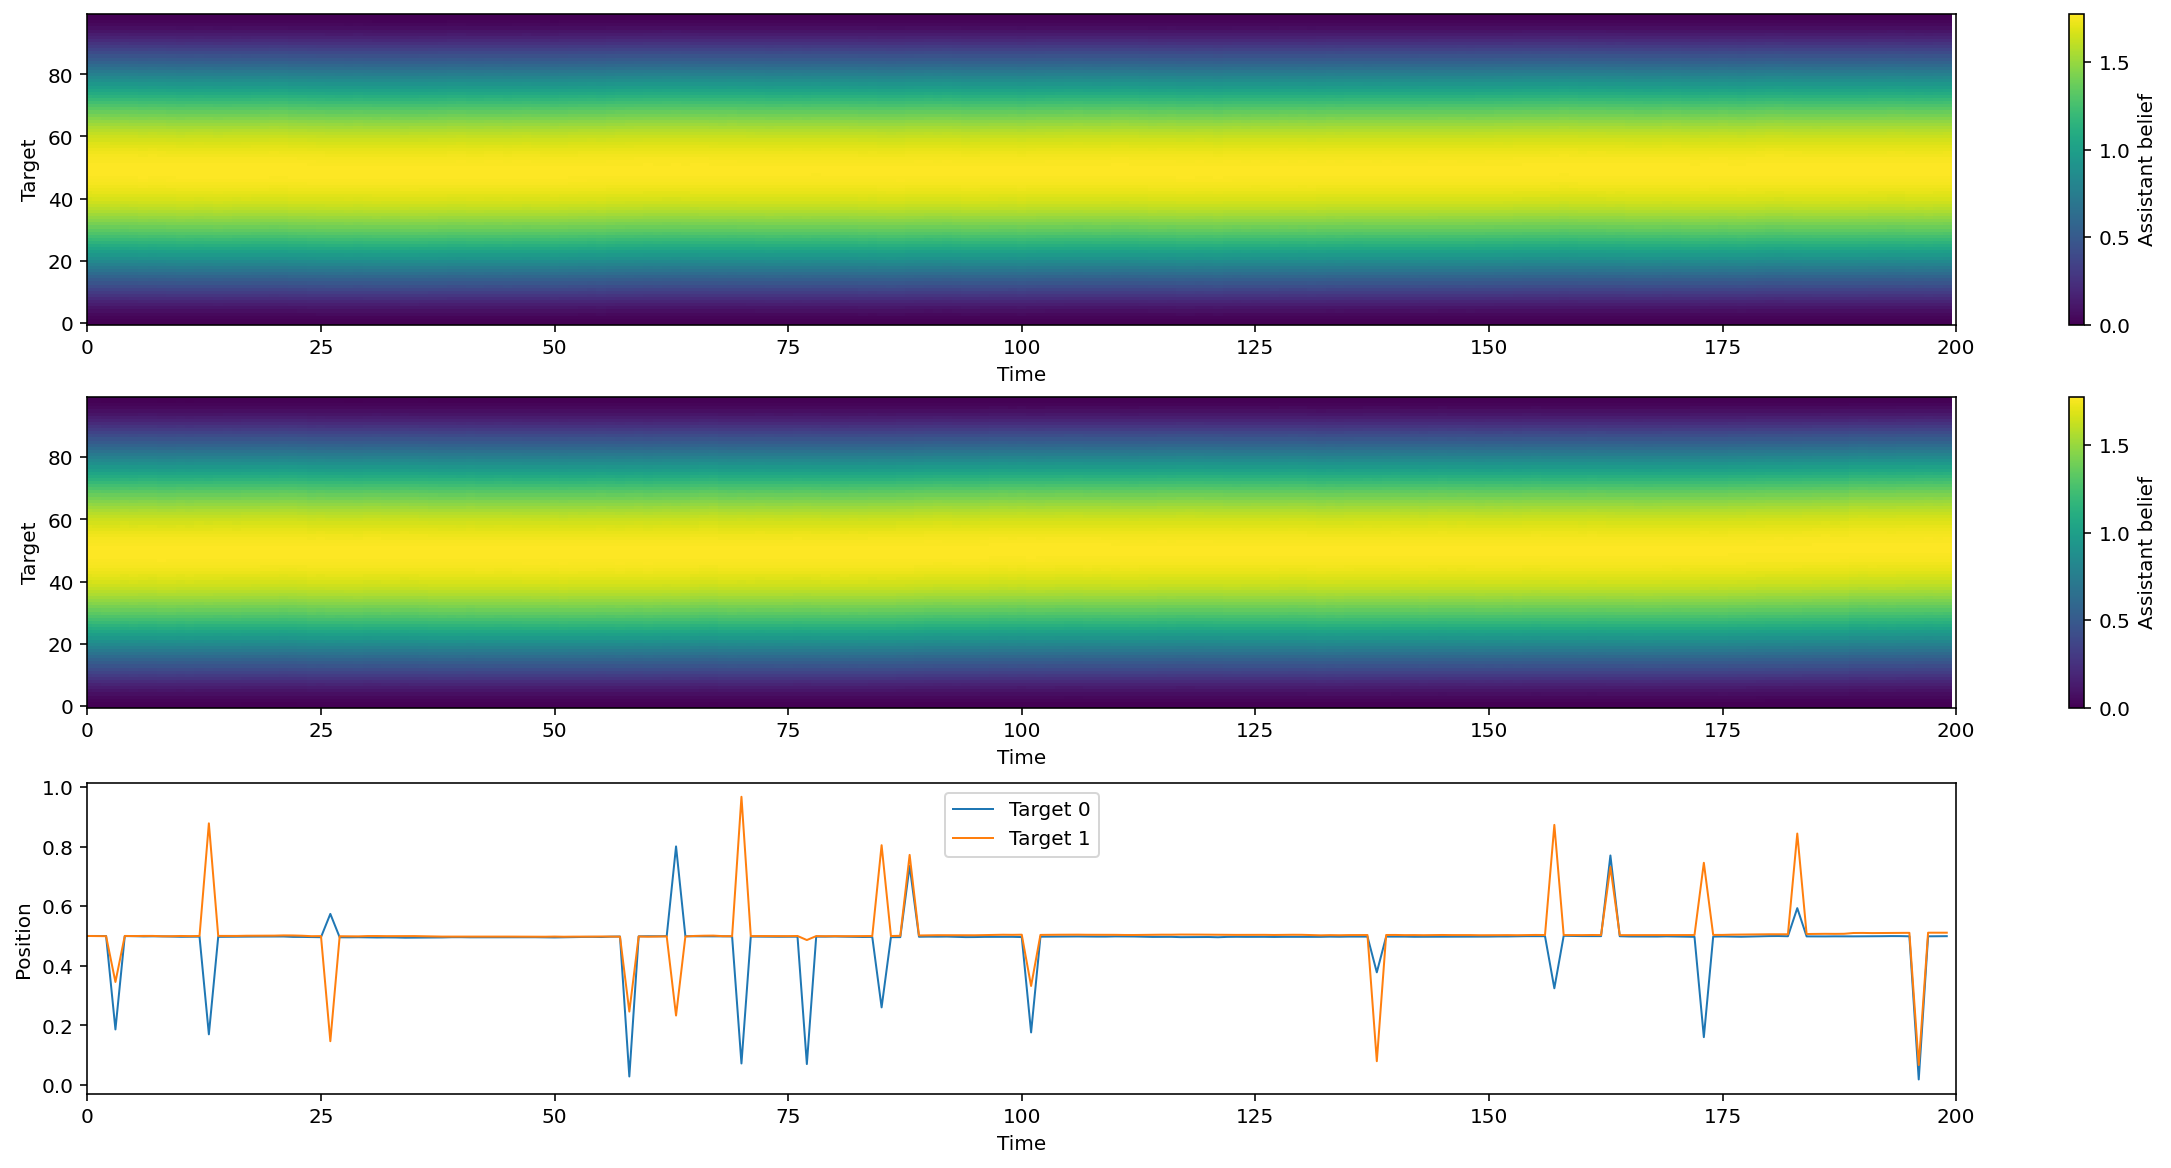

In [25]:
# Create figure
fig, axes = plt.subplots(
    nrows=n_targets+1, figsize=(15, 8),
    constrained_layout=True)

for target in range(n_targets):
    ax = axes[target]
    
    x = torch.linspace(0., 1., 100)
    
    belief = []
    
    for epoch in range(n_epochs):
        log_c0, log_c1 = belief_trace[epoch, target, :]
        belief_epoch = torch.distributions.Beta(concentration0=np.exp(log_c0), concentration1=np.exp(log_c1)).log_prob(x).exp().numpy()
        belief.append(belief_epoch)
        
    im = ax.imshow(
        np.transpose(belief),
        interpolation="nearest",
        aspect="auto",
        cmap="viridis",
        # vmin=0, vmax=1,
    )

#     epochs = np.arange(n_epochs)

#     a = np.asarray(user_action_trace)
#     idx = a == 0
#     ax.scatter(epochs[idx], assistant_action_trace[idx], c="none", marker='^', edgecolor="C1")
#     idx = a == 1
#     ax.scatter(epochs[idx], assistant_action_trace[idx], c='red', marker='v')

    ax.invert_yaxis()
    ax.yaxis.get_major_locator().set_params(integer=True)

    ax.set_xlim([0, n_epochs])

    ax.set_xlabel("Time")
    ax.set_ylabel("Target")

    cb = fig.colorbar(im, ax=ax)
    cb.set_label("Assistant belief")

ax = axes[-1]
for i, x in enumerate(assistant_action_trace):
    ax.plot(x, label=f"Target {i}", lw=1)

ax.set_xlabel("Time")
ax.set_ylabel("Position")

ax.set_xlim([0, n_epochs])

ax.legend();

In [27]:
belief

[array([0.        , 0.00704058, 0.02276194, 0.04487976, 0.07226305,
        0.10412103, 0.13983397, 0.17888696, 0.22083578, 0.2652883 ,
        0.31189218, 0.36032674, 0.41029784, 0.4615337 , 0.5137804 ,
        0.5668023 , 0.620377  , 0.6742963 , 0.7283637 , 0.7823933 ,
        0.8362103 , 0.88964814, 0.94254994, 0.9947667 , 1.0461566 ,
        1.0965866 , 1.1459297 , 1.1940656 , 1.240881  , 1.2862684 ,
        1.3301259 , 1.3723584 , 1.4128767 , 1.4515945 , 1.4884342 ,
        1.5233209 , 1.5561863 , 1.5869668 , 1.6156023 , 1.6420392 ,
        1.6662282 , 1.6881251 , 1.707689  , 1.7248842 , 1.7396814 ,
        1.7520512 , 1.7619742 , 1.7694323 , 1.774411  , 1.7769023 ,
        1.7769028 , 1.774411  , 1.7694323 , 1.7619742 , 1.7520512 ,
        1.7396809 , 1.7248845 , 1.707689  , 1.6881251 , 1.6662285 ,
        1.6420395 , 1.6156023 , 1.5869664 , 1.5561863 , 1.5233209 ,
        1.4884342 , 1.4515945 , 1.4128767 , 1.3723584 , 1.3301259 ,
        1.2862684 , 1.2408806 , 1.1940656 , 1.14

In [33]:
x = torch.linspace(0., 1., 100)
plt.plot(x.numpy(), torch.distributions.Beta(concentration0=np.log(1.0).exp(), concentration1=np.log(1.0).exp()).log_prob(x).exp().numpy())

AttributeError: 'numpy.float64' object has no attribute 'exp'

In [34]:
np.log(1.0)

0.0